In [1]:
import numpy as np
from pgmpy.models import MarkovNetwork
from pgmpy.factors.discrete import DiscreteFactor
from pgmpy.inference import BeliefPropagation
import itertools

import networkx as nx
import matplotlib.pyplot as plt


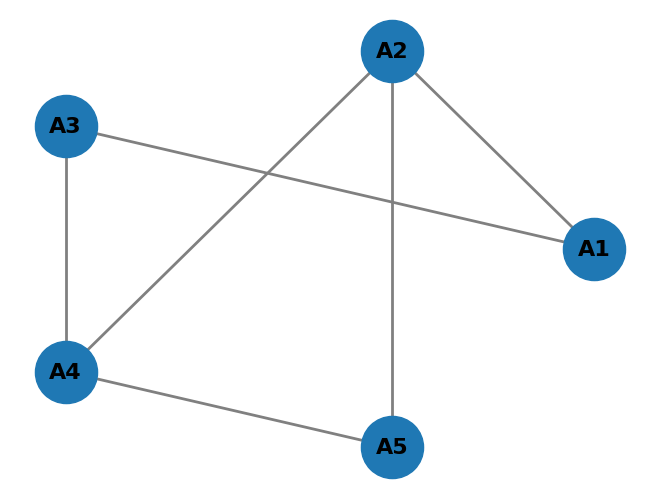

In [2]:
model = MarkovNetwork([("A1", "A2"), ("A1", "A3"), ("A2", "A4"), ("A2", "A5"), ("A3", "A4"), ("A4", "A5")])


pos = nx.circular_layout(model)
nx.draw(model, pos=pos, with_labels=True,
        node_size=2000, font_size=16, font_weight='bold',
        edge_color='gray', width=2)



In [3]:
cliques = list(nx.find_cliques(model))

for i, clique in enumerate(cliques, 1):
    print(f"Clique {i}: {clique}")


Clique 1: ['A4', 'A3']
Clique 2: ['A4', 'A2', 'A5']
Clique 3: ['A1', 'A3']
Clique 4: ['A1', 'A2']


In [4]:
values = [-1, 1]

factor_values1 = []
for a2 in values:
    for a4 in values:
        for a5 in values:
            factor_values1.append(np.exp(2*a2+4*a4+5*a5))

factor_a2_a4_a5 = DiscreteFactor(
    ["A2", "A4", "A5"],
    cardinality=[2, 2, 2],
    values=factor_values1
)

factor_values2 = []
for a1 in values:
    for a2 in values:
        factor_values2.append(np.exp(1*a1+2*a2))

factor_a1_a2 = DiscreteFactor(
    ["A1", "A2"],
    cardinality=[2, 2],
    values=factor_values2
)

factor_values3 = []
for a1 in values:
    for a3 in values:
        factor_values3.append(np.exp(1*a1+3*a3))

factor_a1_a3 = DiscreteFactor(
    ["A1", "A3"],
    cardinality=[2, 2],
    values=factor_values3
)

factor_values4 = []
for a3 in values:
    for a4 in values:
        factor_values4.append(np.exp(3*a3+4*a4))

factor_a3_a4 = DiscreteFactor(
    ["A3", "A4"],
    cardinality=[2, 2],
    values=factor_values4
)

product = factor_a2_a4_a5 * factor_a1_a2 * factor_a1_a3 * factor_a3_a4
product.normalize()

print(product)

+-------+-------+-------+-------+-------+-----------------------+
| A5    | A4    | A2    | A3    | A1    |   phi(A5,A4,A2,A3,A1) |
+=======+=======+=======+=======+=======+=======================+
| A5(0) | A4(0) | A2(0) | A3(0) | A1(0) |                0.0000 |
+-------+-------+-------+-------+-------+-----------------------+
| A5(0) | A4(0) | A2(0) | A3(0) | A1(1) |                0.0000 |
+-------+-------+-------+-------+-------+-----------------------+
| A5(0) | A4(0) | A2(0) | A3(1) | A1(0) |                0.0000 |
+-------+-------+-------+-------+-------+-----------------------+
| A5(0) | A4(0) | A2(0) | A3(1) | A1(1) |                0.0000 |
+-------+-------+-------+-------+-------+-----------------------+
| A5(0) | A4(0) | A2(1) | A3(0) | A1(0) |                0.0000 |
+-------+-------+-------+-------+-------+-----------------------+
| A5(0) | A4(0) | A2(1) | A3(0) | A1(1) |                0.0000 |
+-------+-------+-------+-------+-------+-----------------------+
| A5(0) | 

In [5]:
model.add_factors(factor_a2_a4_a5, factor_a1_a2, factor_a1_a3, factor_a3_a4)
model.get_factors()

[<DiscreteFactor representing phi(A2:2, A4:2, A5:2) at 0x20afb099e80>,
 <DiscreteFactor representing phi(A1:2, A2:2) at 0x20afb096710>,
 <DiscreteFactor representing phi(A1:2, A3:2) at 0x20af9af1590>,
 <DiscreteFactor representing phi(A3:2, A4:2) at 0x20afb200770>]

In [6]:
bp_infer = BeliefPropagation(model)

marginals = bp_infer.map_query(variables=["A1", "A2", "A3", "A4", "A5"])

print(marginals)

{'A1': 1, 'A2': 1, 'A3': 1, 'A4': 1, 'A5': 1}


In [7]:
map_prob = 1.0

for factor in [factor_a2_a4_a5, factor_a1_a2, factor_a1_a3, factor_a3_a4]:

    state = tuple([marginals[var] for var in factor.variables])
    map_prob *= factor.get_value(**{var: marginals[var] for var in factor.variables})


print(f"Unnormalized Joint Probability: {map_prob:.6e}")

Unnormalized Joint Probability: 7.200490e+10


In [8]:
np.random.seed(42)

In [9]:
def create_image():
    image = np.zeros((5, 5))
    for i in range(5):
        for j in range(5):
            image[i, j] = np.random.choice([0, 1])

    return image

original = create_image()
print(original)

[[0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 1. 1. 1. 0.]
 [1. 0. 1. 1. 1.]]


In [10]:
def add_noise(image, noise_percentage=0.1):
    noisy_image = image.copy()
    flattened_image = noisy_image.flatten()
    num_pixels = len(flattened_image)
    num_noise_pixels = int(noise_percentage * num_pixels)

    noise_indices = np.random.choice(num_pixels, num_noise_pixels, replace=False)

    for idx in noise_indices:
        flattened_image[idx] = 1 - flattened_image[idx]

    return flattened_image.reshape(image.shape)

noisy = add_noise(original)
print(noisy)


[[0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 1. 0. 1. 0.]
 [1. 0. 1. 0. 1.]]


In [11]:
def create_markov_network(image_shape, lambda_reg=2.0):

    row, cols = image_shape
    model = MarkovNetwork()

    # adding the nodes
    nodes = []
    for i in range(row):
        for j in range(cols):
            node_name = f"pixel_{i}_{j}"
            nodes.append(node_name)

    model.add_nodes_from(nodes)

    #adding edges between nodes
    edges = []
    for i in range(row):
        for j in range(cols):
            current_node = f"pixel_{i}_{j}"

            # Right neighbor
            if j < cols - 1:
                right_node = f"pixel_{i}_{j+1}"
                edges.append((current_node, right_node))

            # Bottom neighbor
            if i < row - 1:
                bottom_node = f"pixel_{i+1}_{j}"
                edges.append((current_node, bottom_node))

    model.add_edges_from(edges)

    return model, nodes


markov_network, nodes = create_markov_network((5, 5))

print(f"Markov network created with {len(markov_network.nodes())} Nodes and {len(markov_network.edges())} Edges")

Markov network created with 25 Nodes and 40 Edges


In [12]:
def add_factors(model, noisy_image, lambda_reg=2.0):
    """
    Adding unary and pairwise factors to the markov model

    unary: lambda * (x_l - y_l)^2
    pairwise = (x_i - x_j)^2

    """

    row, cols = noisy_image.shape

    # adding unary factors

    for i in range(row):
        for j in range(cols):
            node_name = f"pixel_{i}_{j}"

            observed_value = noisy_image[i, j]

            # creating a factor to binary variables 0 and 1

            # if x = y: energy=0
            # if x != y then energy is lambda_reg

            factor_values = np.zeros(2)
            for state in [0, 1]:
                if state == observed_value:
                    energy = 0
                else:
                    energy = lambda_reg

                factor_values[state] = np.exp(-energy)

            unary_factor = DiscreteFactor([node_name], [2], factor_values)
            model.add_factors(unary_factor)
    # adding pairwise factors

    for edge in model.edges():
        node1, node2 = edge


        factor_values = np.ones((2, 2))

        for state1 in [0, 1]:
            for state2 in [0, 1]:
                if state1==state2:
                    energy = 0
                else:
                    energy = 1

                factor_values[state1, state2] = np.exp(-energy)

        pairwise_factor = DiscreteFactor([node1, node2], [2, 2], factor_values)
        model.add_factors(pairwise_factor)

    return model


markov_model_ful = add_factors(markov_network, noisy)

print(f"Added factors to the model with {len(markov_model_ful.nodes())} Nodes and {len(markov_model_ful.edges())} Edges")
print(markov_model_ful.get_factors())

print(markov_model_ful.check_model())



Added factors to the model with 25 Nodes and 40 Edges
[<DiscreteFactor representing phi(pixel_0_0:2) at 0x20afd4cee50>, <DiscreteFactor representing phi(pixel_0_1:2) at 0x20afd4cf0d0>, <DiscreteFactor representing phi(pixel_0_2:2) at 0x20afd4cf150>, <DiscreteFactor representing phi(pixel_0_3:2) at 0x20afd4cf250>, <DiscreteFactor representing phi(pixel_0_4:2) at 0x20afd4cf350>, <DiscreteFactor representing phi(pixel_1_0:2) at 0x20afd4cf450>, <DiscreteFactor representing phi(pixel_1_1:2) at 0x20afd4cf550>, <DiscreteFactor representing phi(pixel_1_2:2) at 0x20afd4cf650>, <DiscreteFactor representing phi(pixel_1_3:2) at 0x20afd4cf750>, <DiscreteFactor representing phi(pixel_1_4:2) at 0x20afd4cf8d0>, <DiscreteFactor representing phi(pixel_2_0:2) at 0x20afd4cf9d0>, <DiscreteFactor representing phi(pixel_2_1:2) at 0x20afd4cfad0>, <DiscreteFactor representing phi(pixel_2_2:2) at 0x20afd4cfbd0>, <DiscreteFactor representing phi(pixel_2_3:2) at 0x20afd4cfcd0>, <DiscreteFactor representing phi(pi

In [13]:
def denoise_image(model, node_names, image_shape):

    bp = BeliefPropagation(model)

    map_result = bp.map_query(variables=node_names)

    rows, cols = image_shape
    denoised_image = np.zeros(image_shape)

    for i in range(rows):
        for j in range(cols):
            node_name = f"pixel_{i}_{j}"
            denoised_image[i, j] = map_result[node_name]

    return denoised_image, bp

result_denoise, bp_inference = denoise_image(markov_model_ful, nodes, (5, 5))

print(result_denoise)

[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]


In [14]:
def calculate_accuracy(original, denoised):
    return np.mean(original == denoised) * 100


original_accuracy = calculate_accuracy(original, noisy)
bp_accuracy = calculate_accuracy(original_accuracy, result_denoise)

In [15]:
def calculate_energy(image, noisy_image, lambda_reg=2.0):
    row, cols = image.shape
    energy = 0


    for i in range(row):
        for j in range(cols):
            if image[i, j] != noisy_image[i, j]:
                energy += lambda_reg

    for i in range(row):
        for j in range(cols-1):
            if image[i, j] != image[i, j+1]:
                energy += lambda_reg

    for i in range(row-1):
        for j in range(cols):
            if image[i, j] != image[i+1, j]:
                energy += lambda_reg

    return energy


noise_energy = calculate_energy(noisy, noisy, lambda_reg=2.0)
bp_energy = calculate_energy(result_denoise, noisy, lambda_reg=2.0)

In [16]:
print(f"Original Accuracy: {original_accuracy:.2f}%")
print(f"BP Accuracy: {bp_accuracy:.2f}%")
print(f"Noise Energy: {noise_energy:.2f}")
print(f"BP Energy: {bp_energy:.2f}")

Original Accuracy: 92.00%
BP Accuracy: 0.00%
Noise Energy: 50.00
BP Energy: 18.00
